In [2]:
#imports

In [3]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from lightgbm import LGBMRegressor
from IPython.display import display
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
from copy import deepcopy

In [4]:
#import data
train_df = pd.read_csv(r"C:\Users\Nathaniel\Downloads\Data_Train.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv(r"C:\Users\Nathaniel\Downloads\Data_Test.csv")
test_df = test_df.iloc[:, 1:]

In [5]:
display(train_df.head())

print(f"\nDimensions: {train_df.shape[0]} rows × {train_df.shape[1]} columns")

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,5274,08/07/2018,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,Yes
1,1185,19/01/2018,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,Yes
2,6473,27/08/2018,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,Yes
3,602,26/12/2017,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,Yes
4,5656,24/07/2018,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,Yes



Dimensions: 7008 rows × 13 columns


In [6]:
display(test_df.head())

print(f"\nDimensions: {test_df.shape[0]} rows × {test_df.shape[1]} columns")

,ID,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,7274,30/09/2018,1,17.5,66,0.5,2000,11.0,0.00,0.0,0.0,No
1,7122,23/09/2018,17,24.1,41,2.4,2000,10.0,1.17,0.0,0.0,Yes
2,7510,09/10/2018,21,16.8,52,1.6,2000,6.8,0.00,0.0,0.0,No
3,8171,06/11/2018,10,11.7,62,0.5,521,4.6,0.77,0.0,0.0,No
4,7053,20/09/2018,20,19.1,77,2.2,1834,14.9,0.00,0.0,0.0,Yes



Dimensions: 1752 rows × 12 columns


In [7]:
#add data

In [8]:
#change Date dtype to datetime, and FunctDay dtype to category
train_df['Date'] = pd.to_datetime(train_df['Date'], format = '%d/%m/%Y')
train_df['Functioning Day'] = train_df['Functioning Day'].astype('category')

In [9]:
#add Holiday column for the UK in 2018
holiday_url = 'https://www.timeanddate.com/holidays/uk/2018'

#error when importing time and date
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(holiday_url, headers=headers)

holiday_data = pd.read_html(holiday_url)

holiday_df = holiday_data[0]
holiday_df.columns = ['Date', 'Day', 'Holiday', 'Type', 'Details']
holiday_df.drop(columns=['Details'], inplace=True)

In [10]:
#the url data has change multiple time from d-m to m-d, so we need to make the data d-m
def standardize_date_format(date_str):
    date_str = str(date_str)
    
    try:
        date = datetime.strptime(date_str, "%b %d")
        return date.strftime("%d %b")
    except ValueError:
        try:
            date = datetime.strptime(date_str, "%d %b")
            return date.strftime("%d %b")
        except ValueError:
            return None

holiday_df['Date'] = holiday_df['Date'].apply(standardize_date_format)
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%d %b', errors='coerce', dayfirst=True)

In [11]:
#set the Holiday column value as 'Not a Holiday'
train_df['Holiday'] = 'Not a Holiday'

In [12]:
#if holiday, set as 'Holiday', only using the month and day, assuming every year the holiday date is the same
train_df['Month_Day'] = train_df['Date'].dt.strftime('%m-%d')
holiday_df['Month_Day'] = holiday_df['Date'].dt.strftime('%m-%d')

for index, row in train_df.iterrows():
    month_day = row['Month_Day']
    if month_day in holiday_df['Month_Day'].values:
        holiday_name = holiday_df.loc[holiday_df['Month_Day'] == month_day, 'Holiday'].iloc[0]
        train_df.at[index, 'Holiday'] = 'Holiday'
        
train_df.drop(columns=['Month_Day'], inplace=True)

In [13]:
#add Seasons column for the UK in 2018
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month

def get_season(month, day):
    if (month == 3 and 20 <= day <= 31) or (month == 4 and 1 <= day <= 30) or (month == 5 and 1 <= day <= 31) or (month == 6 and 1 <= day <= 20):
        return 'Spring'
    elif (month == 6 and 21 <= day <= 30) or (month == 7 and 1 <= day <= 31) or (month == 8 and 1 <= day <= 31) or (month == 9 and 1 <= day <= 21):
        return 'Summer'
    elif (month == 9 and 22 <= day <= 30) or (month == 10 and 1 <= day <= 31) or (month == 11 and 1 <= day <= 30) or (month == 12 and 1 <= day <= 20):
        return 'Fall'
    else:
        return 'Winter'

def apply_season(row):
    return get_season(row['Month'], row['Day'])

In [14]:
train_df['Seasons'] = train_df.apply(apply_season, axis=1)
train_df.drop(columns=['Month', 'Day'], inplace=True)

In [15]:
train_df

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Holiday,Seasons
0,5274,2018-07-08,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,Yes,Not a Holiday,Summer
1,1185,2018-01-19,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,Yes,Not a Holiday,Winter
2,6473,2018-08-27,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,Yes,Not a Holiday,Summer
3,602,2017-12-26,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,Yes,Not a Holiday,Winter
4,5656,2018-07-24,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,Yes,Not a Holiday,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,5825,2018-07-31,763,16,37.0,38,1.2,2000,20.3,2.07,0.0,0.0,Yes,Not a Holiday,Summer
7004,2206,2018-03-02,396,21,1.0,34,1.4,1880,-13.1,0.00,0.0,0.0,Yes,Holiday,Winter
7005,4374,2018-06-01,306,5,17.8,75,1.0,1210,13.3,0.00,0.0,0.0,Yes,Not a Holiday,Spring
7006,4597,2018-06-10,1442,12,23.2,50,2.2,1988,12.1,2.45,0.0,0.0,Yes,Holiday,Spring


In [16]:
#change Holiday dtype to category
train_df['Holiday'] = train_df['Holiday'].astype('category')
train_df['Seasons'] = train_df['Seasons'].astype('category')
train_df.dtypes

ID                                    int64
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Functioning Day                    category
Holiday                            category
Seasons                            category
dtype: object

In [17]:
#analysis

In [18]:
#encoded categorical dtype
train_df['Seasons_encoded'] = 0
for i, season in enumerate(train_df['Seasons']):
    if season == 'Summer':
        train_df.at[i, 'Seasons_encoded'] = 0
    elif season == 'Fall':
        train_df.at[i, 'Seasons_encoded'] = 1
    elif season == 'Winter':
        train_df.at[i, 'Seasons_encoded'] = 2
    else:
        train_df.at[i, 'Seasons_encoded'] = 3

train_df['Holiday_encoded'] = 0
for i, holiday in enumerate(train_df['Holiday']):
    if holiday == 'Not a Holiday':
        train_df.at[i, 'Holiday_encoded'] = 0
    else:
        train_df.at[i, 'Holiday_encoded'] = 1

train_df['Functioning_Day_encoded'] = 0
for i, day in enumerate(train_df['Functioning Day']):
    if day == 'No':
        train_df.at[i, 'Functioning_Day_encoded'] = 0
    else:
        train_df.at[i, 'Functioning_Day_encoded'] = 1

In [19]:
train_df['Seasons'] = train_df['Seasons_encoded']
train_df['Holiday'] = train_df['Holiday_encoded']
train_df['Functioning Day'] = train_df['Functioning_Day_encoded']

train_df.drop(columns=['Functioning_Day_encoded', 'Holiday_encoded', 'Seasons_encoded'], inplace=True)

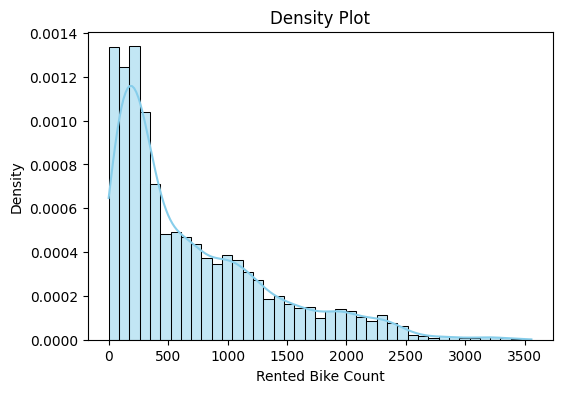

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['Rented Bike Count'], kde=True, stat='density', color='skyblue', edgecolor='black', alpha=0.5)

plt.title('Density Plot')
plt.xlabel('Rented Bike Count')

# Show plot
plt.show()


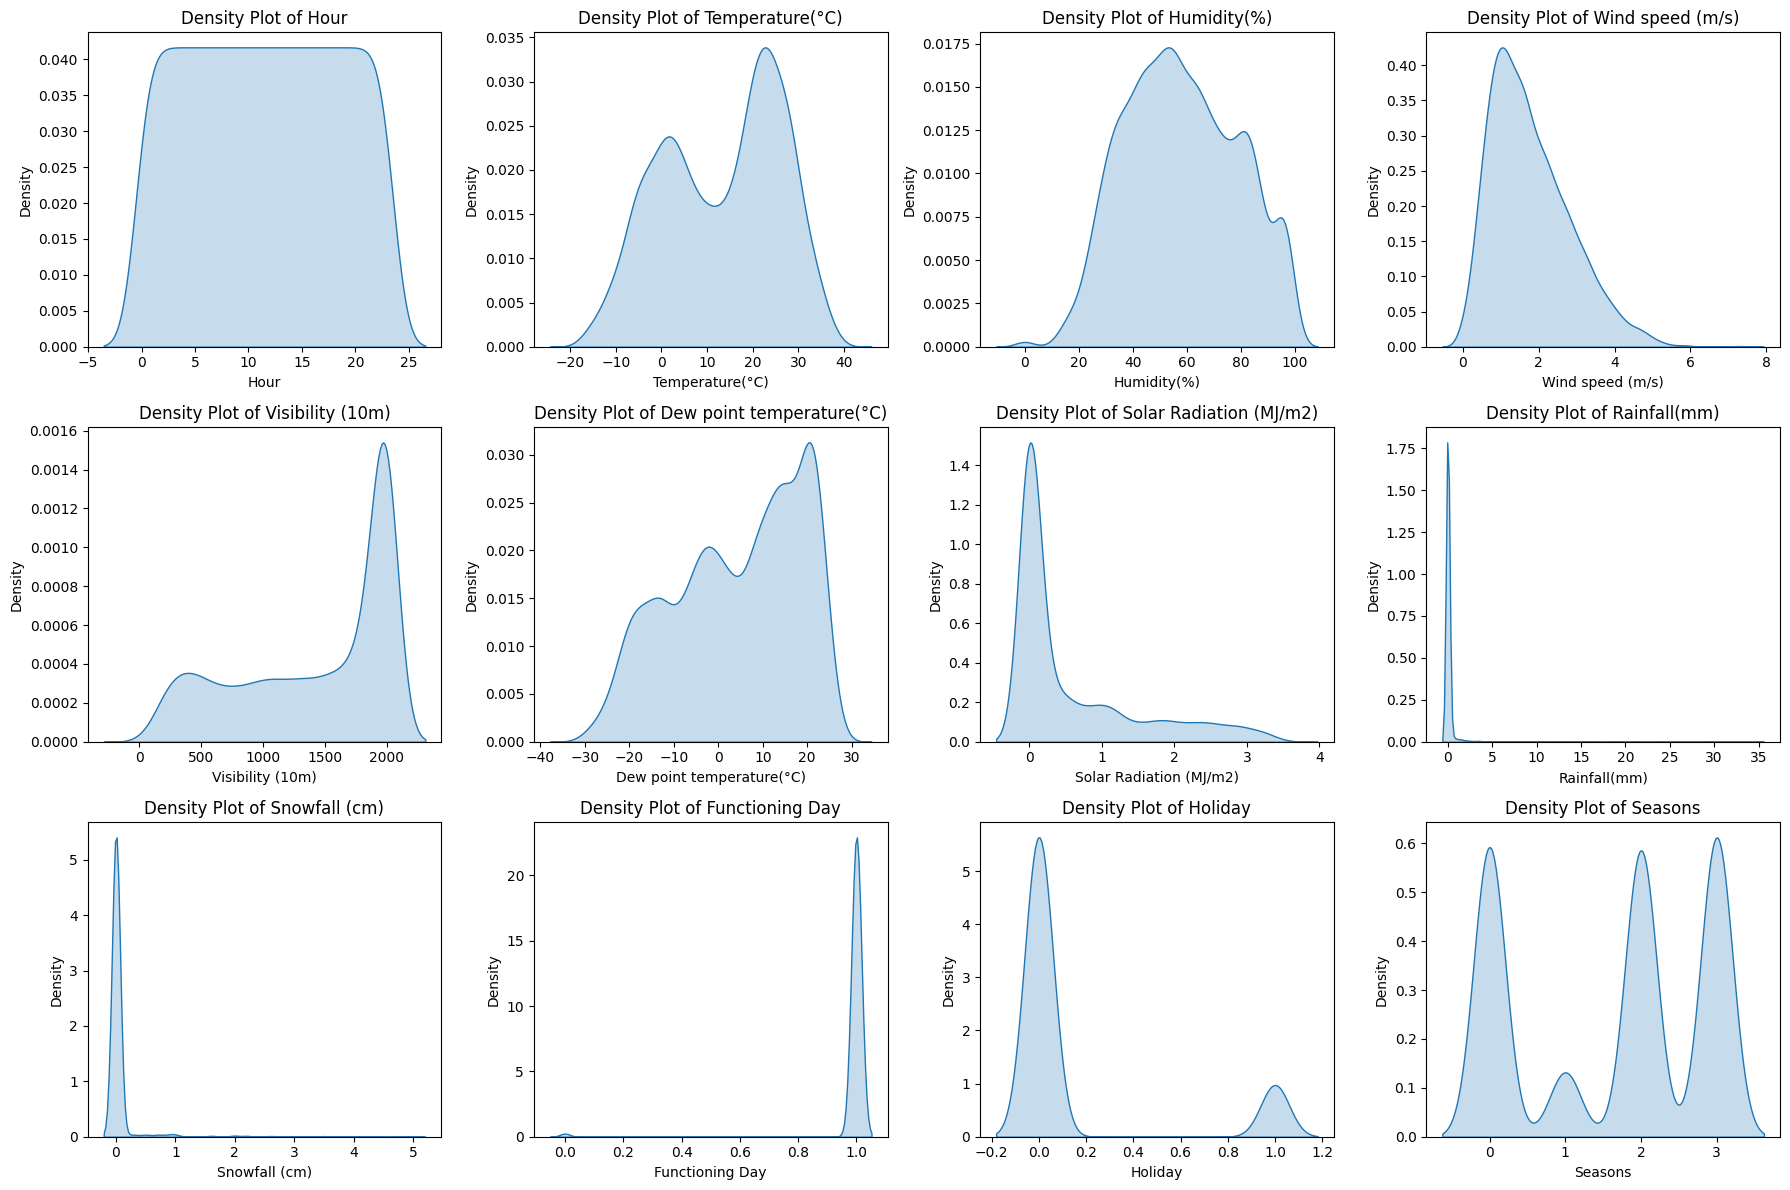

In [21]:
columns_to_dens = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
                   'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Functioning Day', 'Holiday', 'Seasons']

num_plots_density = len(columns_to_dens)
num_rows_density = (num_plots_density + 3) // 4

plt.figure(figsize=(18, 4 * num_rows_density))

for i, column in enumerate(columns_to_dens, 1):
    plt.subplot(num_rows_density, 4, i)
    sns.kdeplot(train_df[column], fill=True)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

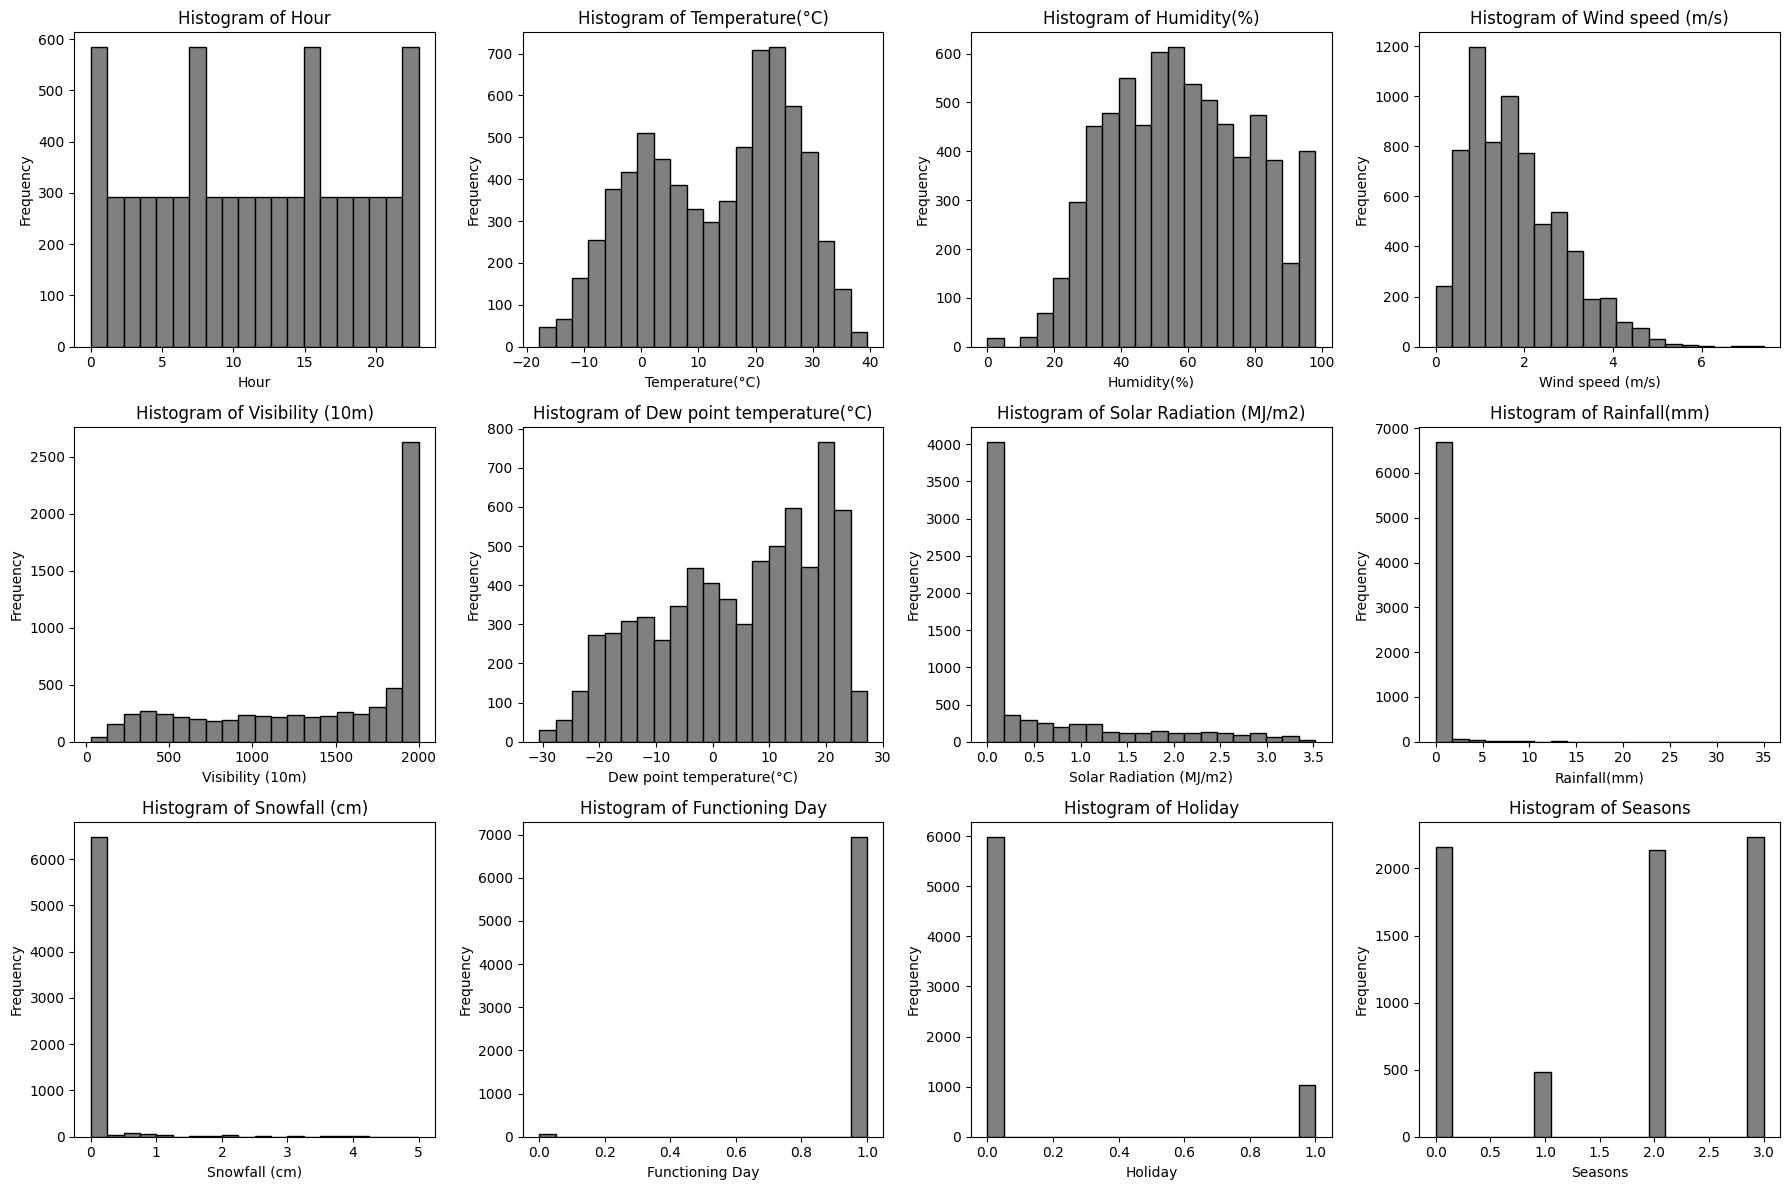

In [22]:
#plot each variables
columns_to_plot = columns_to_dens

num_plots = len(columns_to_plot)
num_rows = (num_plots + 2) // 4

plt.figure(figsize=(18, 4 * num_rows))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, 4, i)
    plt.hist(train_df[column], bins=20, color='grey', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

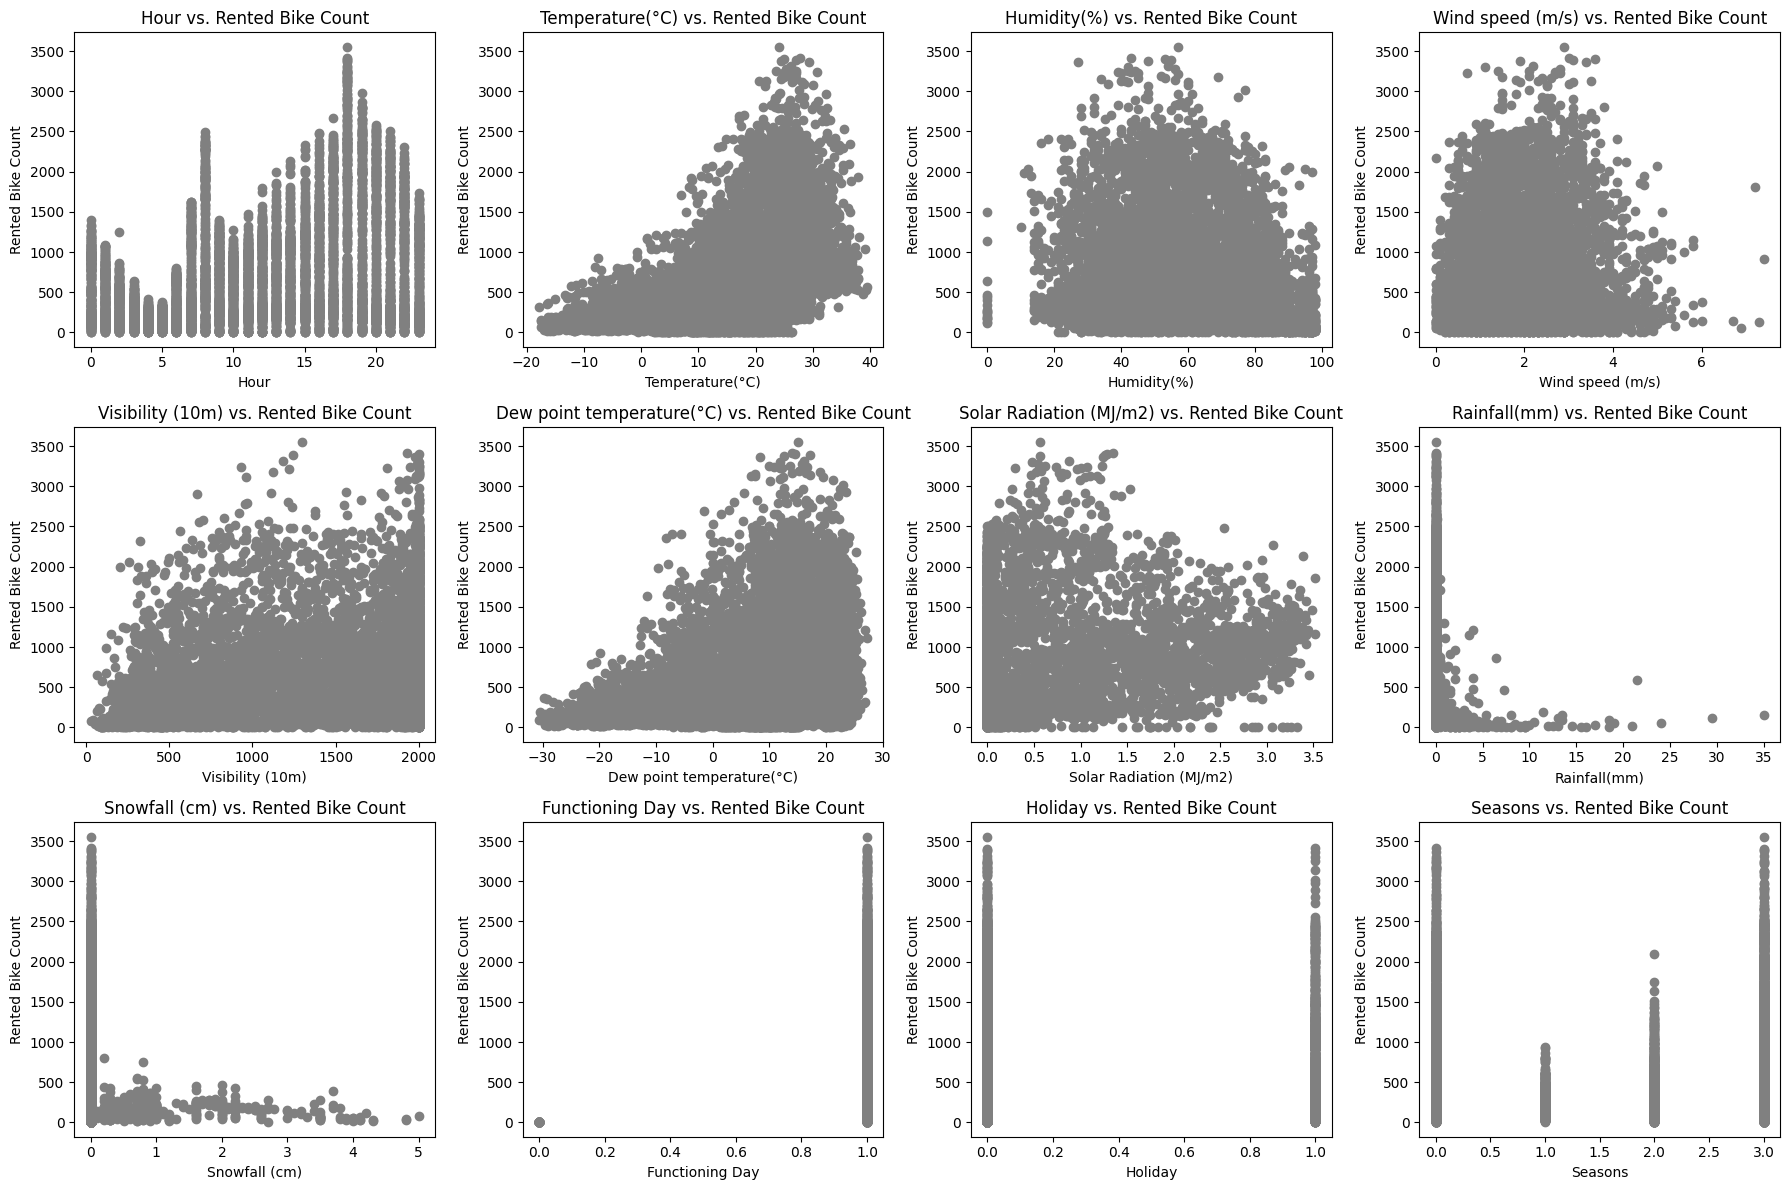

In [23]:
num_plots = len(columns_to_plot)
num_rows = (num_plots + 3) // 4

plt.figure(figsize=(18, 4 * num_rows))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, 4, i)
    plt.scatter(train_df[column], train_df['Rented Bike Count'], color='grey')
    plt.xlabel(column)
    plt.ylabel('Rented Bike Count')
    plt.title(f'{column} vs. Rented Bike Count')

plt.tight_layout()
plt.show()

On non functioning day, the rented bike count is always zero

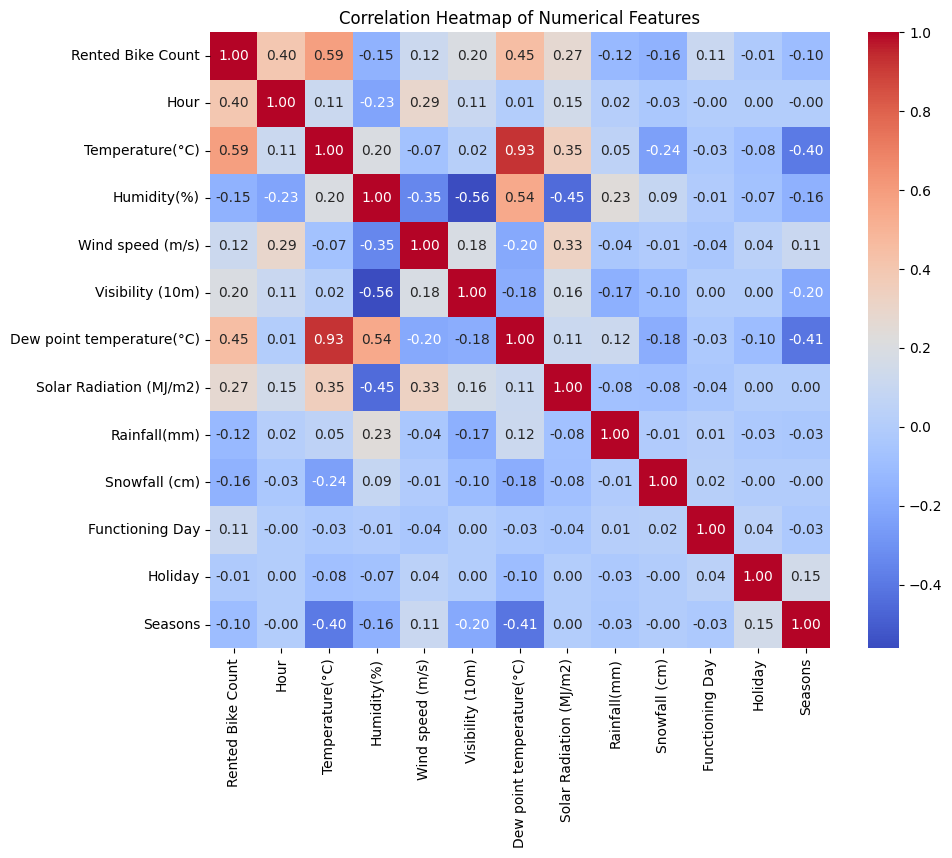

In [24]:
numeric_data = train_df.select_dtypes(include=['int64', 'float64']).drop(columns=['Unnamed: 0', 'ID'], errors='ignore')

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [25]:
correlations = numeric_data.corr()['Rented Bike Count'].sort_values(ascending=False)
correlations

Rented Bike Count            1.000000
Temperature(°C)              0.587260
Dew point temperature(°C)    0.445142
Hour                         0.400722
Solar Radiation (MJ/m2)      0.272875
Visibility (10m)             0.195944
Wind speed (m/s)             0.121473
Functioning Day              0.108063
Holiday                     -0.012682
Seasons                     -0.099561
Rainfall(mm)                -0.116596
Humidity(%)                 -0.153534
Snowfall (cm)               -0.158035
Name: Rented Bike Count, dtype: float64

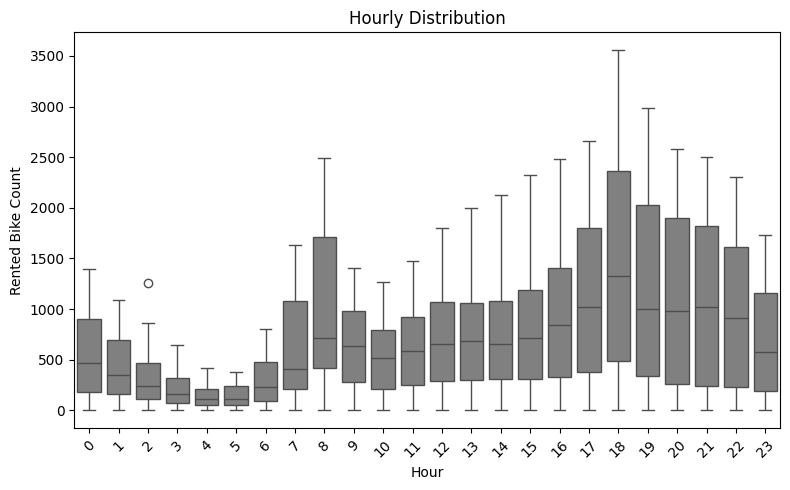

In [26]:
#hour distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x='Hour', y='Rented Bike Count', data=train_df, color='gray')  # Set color to gray
plt.title('Hourly Distribution')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_15916\3756671746.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Seasons', data=train_df, palette='Set2')


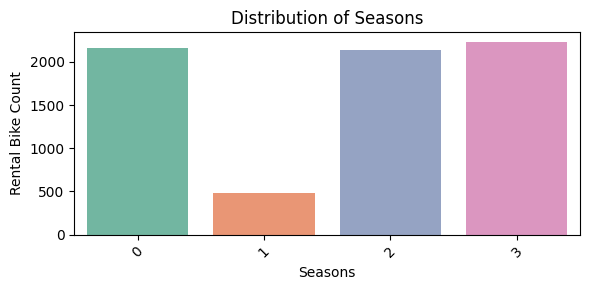

In [27]:
plt.figure(figsize=(6, 3))
sns.countplot(x='Seasons', data=train_df, palette='Set2')
plt.title('Distribution of Seasons')
plt.xlabel('Seasons')
plt.ylabel('Rental Bike Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the fall season, people don't rent as much bikes as the other seasons

In [28]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Wind speed (m/s)    175
Rainfall(mm)        175
Snowfall (cm)       175
dtype: int64

In [29]:
train_df = train_df.copy()
fill_data = ['Rainfall(mm)', 'Snowfall (cm)', 'Wind speed (m/s)']

train_df.loc[:, fill_data] = train_df.loc[:, fill_data].fillna(train_df.loc[:, fill_data].median())

In [30]:
check_anomalies =  numeric_data.drop(columns=['Rented Bike Count'], errors='ignore')


for column in check_anomalies:
    column_data = train_df[column].values.reshape(-1, 1)
    
    isolation_forest = IsolationForest(contamination=0.01)
    isolation_forest.fit(column_data)
    anomalies = isolation_forest.predict(column_data)
    
    outlier_count = np.sum(anomalies == -1)
    print(f"Outliers in {column}: {outlier_count}")

Outliers in Hour: 0
Outliers in Temperature(°C): 71
Outliers in Humidity(%): 63
Outliers in Wind speed (m/s): 53
Outliers in Visibility (10m): 70
Outliers in Dew point temperature(°C): 68
Outliers in Solar Radiation (MJ/m2): 63
Outliers in Rainfall(mm): 70
Outliers in Snowfall (cm): 67
Outliers in Functioning Day: 0
Outliers in Holiday: 0
Outliers in Seasons: 0


In [31]:
#apply the train_df changes to test_df

In [32]:
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y')
test_df['Functioning Day'] = test_df['Functioning Day'].astype('category')

holiday_df = holiday_data[0]
holiday_df.columns = ['Date', 'Day', 'Holiday', 'Type', 'Details']
holiday_df.drop(columns=['Details'], inplace=True)

holiday_df['Date'] = holiday_df['Date'].apply(standardize_date_format)
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%d %b', errors='coerce', dayfirst=True)

test_df['Holiday'] = 'Not a Holiday'
test_df['Month_Day'] = test_df['Date'].dt.strftime('%m-%d')
holiday_df['Month_Day'] = holiday_df['Date'].dt.strftime('%m-%d')

for index, row in test_df.iterrows():
    month_day = row['Month_Day']
    if month_day in holiday_df['Month_Day'].values:
        holiday_name = holiday_df.loc[holiday_df['Month_Day'] == month_day, 'Holiday'].iloc[0]
        test_df.at[index, 'Holiday'] = 'Holiday'

test_df.drop(columns=['Month_Day'], inplace=True)

test_df['Day'] = test_df['Date'].dt.day
test_df['Month'] = test_df['Date'].dt.month

test_df['Seasons'] = test_df.apply(apply_season, axis=1)
test_df.drop(columns=['Month', 'Day'], inplace=True)

test_df['Holiday'] = test_df['Holiday'].astype('category')
test_df['Seasons'] = test_df['Seasons'].astype('category')

test_df['Seasons_encoded'] = 0
for i, season in enumerate(test_df['Seasons']):
    if season == 'Summer':
        test_df.at[i, 'Seasons_encoded'] = 0
    elif season == 'Fall':
        test_df.at[i, 'Seasons_encoded'] = 1
    elif season == 'Winter':
        test_df.at[i, 'Seasons_encoded'] = 2
    else:
        test_df.at[i, 'Seasons_encoded'] = 3

test_df['Holiday_encoded'] = 0
for i, holiday in enumerate(test_df['Holiday']):
    if holiday == 'Not a Holiday':
        test_df.at[i, 'Holiday_encoded'] = 0
    else:
        test_df.at[i, 'Holiday_encoded'] = 1

test_df['Functioning_Day_encoded'] = 0
for i, day in enumerate(test_df['Functioning Day']):
    if day == 'No':
        test_df.at[i, 'Functioning_Day_encoded'] = 0
    else:
        test_df.at[i, 'Functioning_Day_encoded'] = 1

test_df['Seasons'] = test_df['Seasons_encoded']
test_df['Holiday'] = test_df['Holiday_encoded']
test_df['Functioning Day'] = test_df['Functioning_Day_encoded']

test_df.drop(columns=['Functioning_Day_encoded', 'Holiday_encoded', 'Seasons_encoded'], inplace=True)

test_df = test_df.copy()
fill_data = ['Rainfall(mm)', 'Snowfall (cm)', 'Wind speed (m/s)']

test_df.loc[:, fill_data] = test_df.loc[:, fill_data].fillna(test_df.loc[:, fill_data].median())

In [33]:
outliers_column = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
                         'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

def winsorize_outliers(df, col):
    isolation_forest = IsolationForest(contamination=0.1)
    outliers = isolation_forest.fit_predict(df[col].values.reshape(-1, 1))
    
    col_copy = df[col].copy()
    df[col] = winsorize(df[col], limits=(0.01, 0.01))
    
    if -1 in outliers:
        col_copy[outliers == -1] = winsorize(col_copy[outliers == -1], limits=(0.01, 0.01))
        df[col] = col_copy

for col in outliers_column:
    winsorize_outliers(train_df, col)
    winsorize_outliers(test_df, col)

In [34]:
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))

In [35]:
selected_columns = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Dew point temperature(°C)',
                    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Functioning Day', 'Holiday', 'Seasons']

train_df_sub = train_df[selected_columns].copy()

X = train_df_sub
y = train_df['Rented Bike Count']

In [36]:
#train RandomForestRegression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [37]:
rf_train = rf_model.predict(X_test)
smape(y_test, rf_train)

29.55924802418724

In [38]:
#train XGBRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
xgb_train = xgb_model.predict(X_test)
smape(y_test, xgb_train)

33.51367621761298

In [46]:
#train LightGBMRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, num_leaves=64)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 5606, number of used features: 12
[LightGBM] [Info] Start training from score 687.114877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(max_depth=6, num_leaves=64)

In [47]:
lgbm_train = lgbm_model.predict(X_test)
smape(y_test, lgbm_train)

30.72385286409401

In [54]:
assert len(lgbm_train) == len(rf_train) == len(xgb_train), "Lengths of predictions should match"

weight_rf = 0.5
weight_xgb = 0.2
weight_nn = 0.3

ensemble_train = (weight_rf * rf_train) + (weight_xgb * xgb_train) + (weight_nn * lgbm_train)
smape(y_test, ensemble_train)

28.801698282360366

In [55]:
test_df_sub = test_df[selected_columns].copy()

In [56]:
#test the models

In [57]:
rf_pred = rf_model.predict(test_df_sub)

In [58]:
xgb_pred = xgb_model.predict(test_df_sub)

In [59]:
lgbm_pred = lgbm_model.predict(test_df_sub)

In [61]:
#based on analysis, every Non Functioning Day, the RBC becomes zero
test_df.loc[test_df['Functioning Day'] == 0, 'Rented Bike Count'] = 0

In [62]:
test_df[['ID', 'Rented Bike Count']].to_csv('predictionheh3.csv', index=False)

In [63]:
from joblib import dump

# Save Random Forest model
dump(rf_model, 'rf_model.joblib')

# Save XGBoost model
dump(xgb_model, 'xgb_model.joblib')

# Save LightGBM model
dump(lgbm_model, 'lgbm_model.joblib')

['lgbm_model.joblib']